# Tutorial: Fermi GBM Detector Responses

Adapted from "Detector Response Files" in the Fermi GBM Data Tools documentation and "Fermi GBM Detector Responses" in the Fermi Gamma-ray Data Tools documentation.

The GBM detector response files allow you to compare a theoretical photon spectrum to an observed count spectrum. In short, a single detector response file is only useful for its corresponding detector, for a given source position on the sky, and a given time (or relatively short time span). Essentially, one file contains one or more detector response matrices (DRMs) encoding the energy dispersion and calibration of incoming photons at different energies to recorded energy channels. The matrix also encodes the effective area of the detector as a function of energy for a given source position relative to the detector pointing. This effective area can change dramatically as there is a strong angular-dependence of the response (and the angular-dependence changes with energy!). A file that contains a single DRM will be named with a ‘.rsp’ extension, and a file containing more than one DRM will be named with a ‘.rsp2’ extension. These can be accessed with `GbmRsp` and `GbmRsp2` classes, respectively. The rsp2 files typically have a DRM generated for every x degrees of spacecraft slew relative to the source, useful for studying the spectrum of transients that may be several tens or hundreds of seconds long (and therefore where the detector pointing is changing singificantly relative to the source).

In this tutorial, we will go through an example of how to use the Fermi Gamma-Ray Tools (GDT) toolkit as well as the core GDT toolkit to read, manipulate, and plot detector response 'rsp2' data from the Fermi Gamma-ray Burst Monitor.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import gdt.missions.fermi 
import gdt.core 

We can open and read response data in a similar way to other kinds of GBM science data. In this example, we will be using an 'rsp2' data file and opening it with the `GbmRsp2` class from the GDT Fermi toolkit; to open an 'rsp' file, you would use the `GbmRsp` class. Be aware that `GbmRsp2` objects and `GbmRsp` objects have slightly different properties, and not everything that can be done with one class can be done with the other. We will use event **120415958** as our example event for the rest of this tutorial.

In [2]:
# classes used to find and open data files
from gdt.core import data_path
from gdt.missions.fermi.gbm.finders import TriggerFtp

# we will be using the GbmRsp2 data class to open the data in this example, which works slightly differently from the GbmRsp class
from gdt.missions.fermi.gbm.response import GbmRsp2

# download a ctime file associated with the triggered event 120415958 and the "n4" detector
rsp_finder = TriggerFtp('120415958')
rsp_finder.get_rsp2(download_dir=data_path.joinpath('120415958'),dets='n4',ctime=False)

# open and read the downloaded rsp2 file
filepath = data_path.joinpath('120415958/glg_cspec_n4_bn120415958_v00.rsp2')
rsp2 = GbmRsp2.open(filepath)
print(rsp2)

Output()

<GbmRsp2: glg_cspec_n4_bn120415958_v00.rsp2;
 trigger time: 356223561.133346; 12 DRMs;
 time range (-129.02604603767395, 477.1912539601326)>


You can see all the metadata in the FITS headers like so:

In [3]:
rsp2.headers.keys()

AttributeError: 'NoneType' object has no attribute 'keys'

In [4]:
rsp2.headers['PRIMARY']

TypeError: 'NoneType' object is not subscriptable

This is an rsp2 file, so there are multiple DRMs contained, covering the specified time range. There are a number of attributes available to us. For example, we can easily determine how many matrices are contained (without having to count the header extensions):

In [5]:
# display number of drms in downloaded file
rsp2.num_drms

12

Other important attributes that we might need to know are the number of photon bins (the energy of the incoming photons) and the number of energy channels:

In [6]:
# display number of energy channels
print('Number of energy channels: {}'.format(rsp2.num_chans))

# display number of input photon bins
print('Number of photon bins: {}'.format(rsp2.num_ebins))

Number of energy channels: 128
Number of photon bins: 140


We can also find the time centroids for each DRM, which are the center times of the interval over which the DRM is valid:

In [7]:
# display the time centroids for each DRM
rsp2.tcent

array([-104.44964603,  -55.29684603,   -8.19209602,   37.37660399,
         84.48130399,  133.12205398,  182.27480397,  251.90785396,
        321.54095396,  370.69370398,  419.84640399,  460.80700397])

An rsp2 file containing multiple DRMs indicates there is a DRM that is most appropriate to use for a given time. We can find the DRM that is closest to our time of interest by using the `nearest_drm()` function with our desired time. 

In [8]:
# return the detector response covering T0
rsp = rsp2.nearest_drm(0.0)
print(rsp)

<GbmRsp: 
 trigger time: 356223561.133346;
 time range (-30.720446050167084, 14.336254000663757);
 140 energy bins; 128 channels>


Notice that this returns a single-DRM response object. We can access the DRM directly, which is a `ResponseMatrix` object:

In [9]:
# access the drm for the response returned above
rsp.drm

<ResponseMatrix: 140 energy bins; 128 channels>

The thing we actually use the DRMs for is to fold a model photon spectrum through the response matrix to return a count spectrum. That model count spectrum can then be compared to the observed count spectrum. For example, we fold a `PowerLaw` photon model through the response:

In [10]:
# import and initialize power law function
from gdt.core.spectra.functions import PowerLaw
pl = PowerLaw()

# fold power law with amplitude=0.01, index=-2.0 through the response to create a model count spectrum
countspec=rsp.fold_spectrum(pl.fit_eval, (0.01, -2.0))

This returns an `EnergyBins` object containing the count spectrum. Let's plot the model count spectrum we just returned using the `Spectrum` class from the GDT Core toolkit:

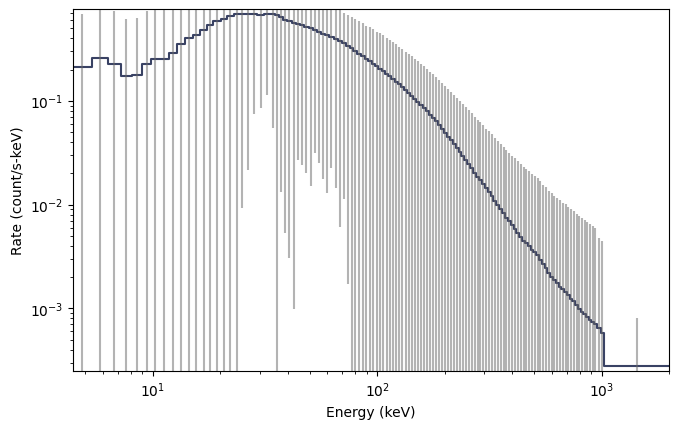

In [11]:
from gdt.core.plot.spectrum import Spectrum

# plot and show the model count spectrum generated above
specplot = Spectrum(data=countspec)
plt.show()

Instead of retrieving the nearest DRM to our time of interest, we can also interpolate the Rsp2 object:

In [12]:
# interpolate over the rsp2 file for T0 and return a single-DRM rsp object
rsp_interp = rsp2.interpolate(0.0)

What does a DRM actually look like? We can make a plot of one using the `ResponsePlot` class:

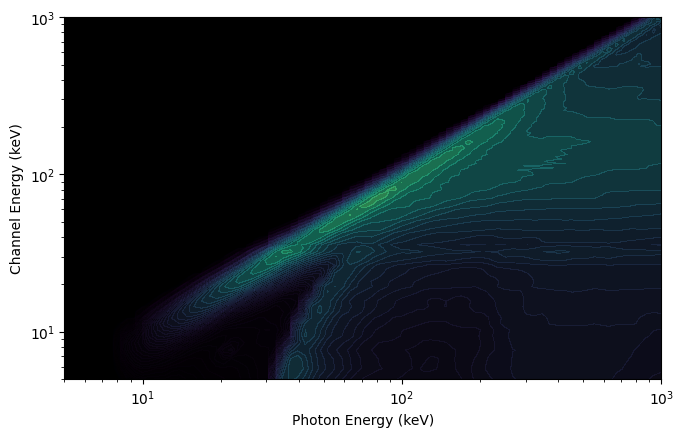

In [13]:
from gdt.core.plot.drm import ResponsePlot

# generate a plot of the interpolated response data
drmplot = ResponsePlot(rsp_interp.drm,colorbar=None)
drmplot.xlim = (5.0, 1000.0)
drmplot.ylim = (5.0, 1000.0)
plt.show()

What we see in the plot is a diagonal edge that contains a majority of the effective area. This approximately linear mapping of photon energy to energy channel is called the photopeak. There is also a bunch of off-diagonal contribution from photons deposited into energy channels lower than the original photon energy. This presence of non-negligible off-diagonal response is one of the reasons that the DRM is not invertible. This particular DRM contains a lot of off-diagonal effective area, in part because this example was made for a very large source angle from the detector normal. You can display the angle between the detector and the source like so:

In [14]:
# display the detector-source angle of this response
rsp_interp.headers['SPECRESP MATRIX']['DET_ANG']

138.3

You can also perform operations to modify the DRM. Specifically, you can change the resolution of the photon energy axis of the DRM or adjust the photon bin edges like so:

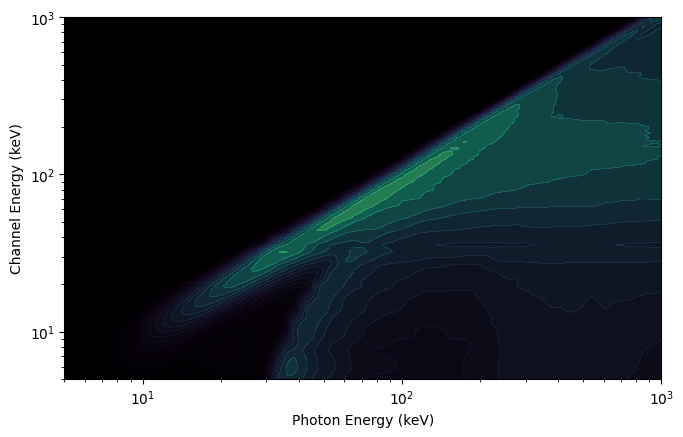

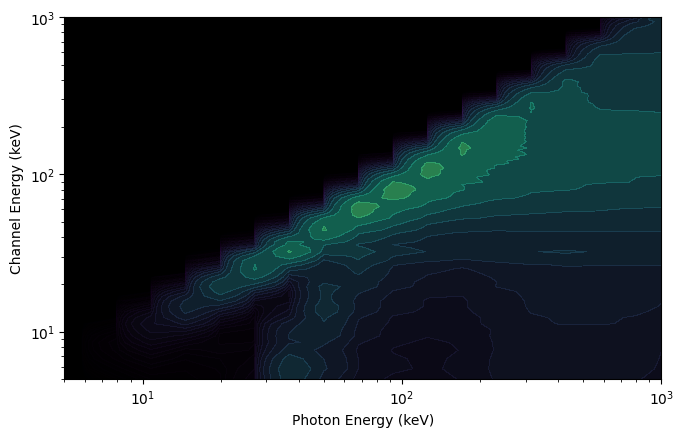

In [15]:
# increase the number of photon bins to 300 (instead of the nominal 140)
rsp_hires = rsp.resample(num_photon_bins=300)
rsp_plot_hires = ResponsePlot(rsp_hires.drm, num_contours=50, colorbar=None)
rsp_plot_hires.xlim = (5.0, 1000.0)
rsp_plot_hires.ylim = (5.0, 1000.0)

# decrease the number of photon bins to 30
rsp_lores = rsp.resample(num_photon_bins=30)
rsp_plot_lores = ResponsePlot(rsp_lores.drm, num_contours=50, colorbar=None)
rsp_plot_lores.xlim = (5.0, 1000.0)
rsp_plot_lores.ylim = (5.0, 1000.0)

While you cannot increase the resolution of the energy channel axis of the DRM, you can rebin that axis to a lower resolution:

AttributeError: 'Colorbar' object has no attribute 'patch'

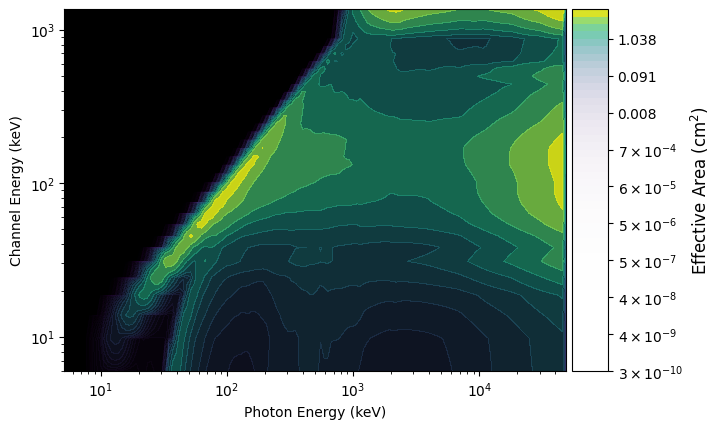

In [16]:
# rebin the energy channel axis by a factor of 4
rsp_rebinned = rsp.rebin(factor=4)
rsp_plot_rebinned = ResponsePlot(rsp_rebinned.drm, num_contours=50)
rsp_plot_rebinned.xlim = (5.0, 1000.0)
rsp_plot_rebinned.ylim = (5.0, 1000.0)

We can also make a plot of the effective area integrated over photon energies using the `PhotonEffectiveArea` class:

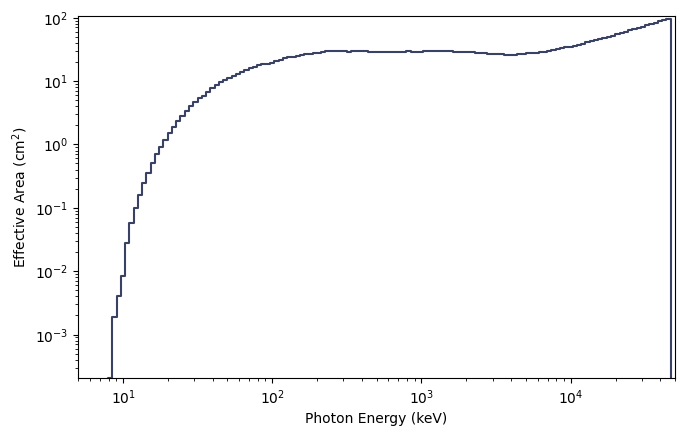

In [17]:
from gdt.core.plot.drm import PhotonEffectiveArea

# plot the effective area of incident photons
effarea_plot = PhotonEffectiveArea(rsp_interp.drm)
plt.show()

Or over energy channels using the `ChannelEffectiveArea` class:

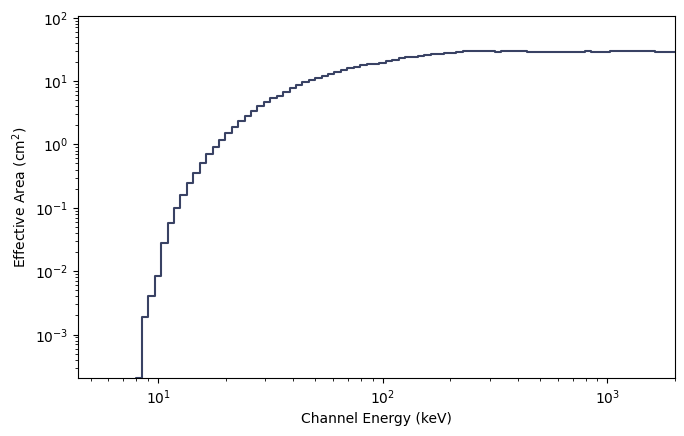

In [18]:
from gdt.core.plot.drm import ChannelEffectiveArea

# plot the effective area of the recorded counts
effarea_plot = ChannelEffectiveArea(rsp_interp.drm)
plt.show()

Congradulations, you've completed the lesson on detector response files!